In [291]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow

from vbpp.model import VBPP
from data_down_events_training import make_estimate_data_for_down

def build_data(user, start_line, end_line, filename):
    num_observations = end_line - start_line
    #events_oral = make_estimate_data(user,start_line,end_line,filename)
    #events = np.unique(events_oral.flatten())
    events = make_estimate_data_for_down(user, start_line, end_line, filename)
    return events, num_observations

def domain_grid(domain, num_points):       #域grid
    return np.linspace(domain.min(axis=1), domain.max(axis=1), num_points)

def domain_area(domain):                   #域面积
    return np.prod(domain.max(axis=1) - domain.min(axis=1))

def build_model(events, domain, num_observations, M=20, variance = 1.0, lengthscales = 0.1):
    #kernel = gpflow.kernels.SquaredExponential()
    kernel = gpflow.kernels.SquaredExponential(variance = variance, lengthscales = lengthscales)  #0.01,0.05,0.1,0.2
    Z = domain_grid(domain, M)                               #均匀切分domain,和events无关
    feature = gpflow.inducing_variables.InducingPoints(Z)    #inducing point（将均匀切分的点作为inducing point）
    q_mu = np.zeros(M)      #均值为0？
    q_S = np.eye(M)         #单位矩阵
    #print (events)
    num_events = len(events)
    beta0 = np.sqrt(num_events / domain_area(domain))       # 事件数/域面积 的开方,是什么？  是第二个模型的offset
    model = VBPP(feature, kernel, domain, q_mu, q_S, beta0=beta0, num_events=num_events, num_observations = num_observations)
    return model

In [365]:
N = 100     #预测点（lambda）
#目标用户信息,用于模型训练
object_user = 's052'
object_data_str_1 = 0
object_data_end_1 = 50

variance = 1.3
lengthscales = 0.6
inducing_num = 9

filename = "./data/DSL-StrongPasswordData.xls"
events,num_observations = build_data(object_user,object_data_str_1, object_data_end_1,filename)
events = np.array(events, float).reshape(-1, 1)

domain_max = max(events) + 0.1
domain = [0,domain_max]
domain = np.array(domain, float).reshape(1, 2)

model = build_model(events, domain, num_observations, M=inducing_num, variance=variance, lengthscales = lengthscales)   #M是 inducing point的数量

def objective_closure():                           #目标函数
    return - model.elbo(events)

gpflow.optimizers.Scipy().minimize(objective_closure, model.trainable_variables)

      fun: 132.14199039964993
 hess_inv: <66x66 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.25138182e-02,  2.42181403e-02, -2.13821006e-02, -2.74567187e-02,
        7.25003403e-02, -1.03857345e-01,  2.56231055e-02, -1.07390705e-03,
       -2.91575118e-02, -7.11267016e-03,  1.43221346e-02, -1.14180670e-02,
       -3.59566327e-03,  2.86286879e-02,  2.95487134e-04,  1.91372217e-02,
       -4.62831057e-03,  8.61216097e-03,  2.35146342e-02, -1.49276818e-02,
       -7.94081910e-03, -4.34321924e-03,  1.61655307e-03,  5.12544202e-03,
        2.30428730e-03, -5.95459174e-03, -2.94619206e-04, -1.44553572e-03,
        2.79468506e-05, -7.71773415e-04, -9.44371092e-03, -7.15962996e-03,
       -3.31276645e-03, -5.72337210e-03,  1.23828886e-02,  4.34427532e-03,
       -1.58647670e-03,  5.00721263e-04, -3.30490998e-03,  3.91694234e-02,
        1.43304533e-01,  6.90607596e-02,  1.36464234e-02, -2.71801089e-02,
       -8.86656572e-03,  1.70061758e-03,  2.63518099e-03,  4.00137072e-03,
 

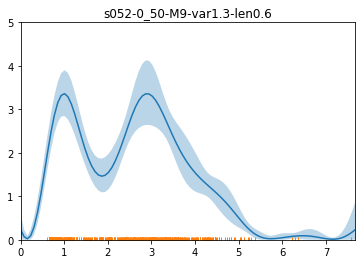

In [366]:
#画强度的估值图
X = domain_grid(domain, N)
lambda_mean, lower, upper = model.predict_lambda_and_percentiles(X)
lower = lower.numpy().flatten()
upper = upper.numpy().flatten()

title_object_1 = object_user+'-'+str(object_data_str_1)+'_'+str(object_data_end_1)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales)

plt.title(title_object_1)
plt.xlim(X.min(), X.max())
plt.ylim(0, 5)
plt.plot(X, lambda_mean)
plt.fill_between(X.flatten(), lower, upper, alpha=0.3)
plt.plot(events, np.zeros_like(events), '|')
plt.show()

In [367]:
N = 100     #预测点（lambda）
#目标用户信息,用于模型训练
object_data_str_2 = 50
object_data_end_2 = 100
'''
variance = 1.0
lengthscales = 0.6
inducing_num = 10
'''

events,num_observations = build_data(object_user,object_data_str_2, object_data_end_2,filename)
events = np.array(events, float).reshape(-1, 1)

domain_max = max(events) + 0.1
domain = [0,domain_max]
domain = np.array(domain, float).reshape(1, 2)

model = build_model(events, domain, num_observations, M=inducing_num, variance=variance, lengthscales = lengthscales)   #M是 inducing point的数量

def objective_closure():                           #目标函数
    return - model.elbo(events)

gpflow.optimizers.Scipy().minimize(objective_closure, model.trainable_variables)

      fun: 22.880704737707333
 hess_inv: <66x66 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.93469279e+01, -2.59912786e+04,  2.57783276e+04, -1.05229300e+02,
        3.38262852e+02,  4.74862389e+01, -5.69640797e+01,  1.66811320e+02,
       -2.22650440e+02, -3.06946744e+01,  1.18385716e+02, -4.98444209e+00,
        4.26762798e+03, -4.23542524e+03, -6.87574416e+01, -3.21490134e+01,
        3.51441414e+01, -3.36273510e+01,  7.20022233e+01, -7.80412099e+01,
        1.36962684e+01, -1.60987182e+00,  7.39668066e-01, -1.24107312e+00,
       -8.70841462e-01, -1.85916981e+00, -1.30163552e+00, -1.57527145e+00,
       -1.06404208e+00,  2.35397676e-02,  4.34015808e+02,  3.69264967e+01,
        5.14388773e+00,  3.62706848e+00,  1.78943922e+01,  6.75462894e+00,
        1.20537725e+01,  4.37944976e+00, -1.06988286e-01, -4.26793302e+02,
        4.32865092e+03, -4.85442232e+00,  4.68429145e+00, -9.74369217e+00,
       -6.58631335e+00, -9.72614671e+00, -5.75116219e+00, -8.83776705e-01,
 

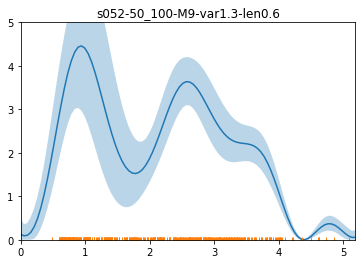

In [368]:
#画强度的估值图
X = domain_grid(domain, N)
lambda_mean, lower, upper = model.predict_lambda_and_percentiles(X)
lower = lower.numpy().flatten()
upper = upper.numpy().flatten()

title_object_2 = object_user+'-'+str(object_data_str_2)+'_'+str(object_data_end_2)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales)

plt.title(title_object_2)
plt.xlim(X.min(), X.max())
plt.ylim(0, 5)
plt.plot(X, lambda_mean)
plt.fill_between(X.flatten(), lower, upper, alpha=0.3)
plt.plot(events, np.zeros_like(events), '|')
plt.show()

In [369]:
N = 100     #预测点（lambda）
#目标用户信息,用于模型训练
object_data_str_3 = 100
object_data_end_3 = 150

'''
variance = 1.0
lengthscales = 0.6
inducing_num = 10
'''

events,num_observations = build_data(object_user,object_data_str_3, object_data_end_3,filename)
events = np.array(events, float).reshape(-1, 1)

domain_max = max(events) + 0.1
domain = [0,domain_max]
domain = np.array(domain, float).reshape(1, 2)

model = build_model(events, domain, num_observations, M=inducing_num, variance=variance, lengthscales = lengthscales)   #M是 inducing point的数量

def objective_closure():                           #目标函数
    return - model.elbo(events)

gpflow.optimizers.Scipy().minimize(objective_closure, model.trainable_variables)

      fun: 0.26795751187406225
 hess_inv: <66x66 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.05812289e-02, -8.36132537e-06, -4.02937900e-02,  2.79253140e-02,
       -5.16907594e-02,  6.36723819e-02,  2.86449137e-02,  2.51253729e-02,
        9.00236552e-04,  2.63510451e-02, -1.16895829e-02, -7.91973606e-03,
       -2.62076527e-03,  2.62345688e-03, -9.19984931e-04,  5.70988046e-03,
        4.85761130e-03,  6.95988748e-03,  1.22400567e-02,  2.77107259e-04,
        3.16894708e-02, -8.23066442e-02,  2.41425274e-03, -4.88273939e-03,
        5.29524119e-03, -4.42519956e-04, -2.99179603e-03,  1.49742218e-03,
       -9.46397802e-04,  6.49370043e-05, -4.87767243e-03,  1.58085033e-02,
       -4.02598813e-03,  3.76252648e-03,  6.64699291e-03,  1.06675418e-04,
        1.64430889e-03,  3.12948209e-03,  2.44407730e-04, -2.03055466e-03,
       -5.29972079e-02, -1.55672833e-01, -4.63870906e-03,  3.36644818e-03,
       -6.20589392e-03,  4.52961135e-03, -5.69985631e-04,  1.41237175e-04,


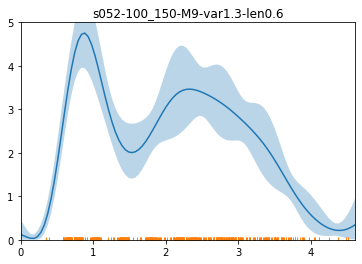

In [370]:
#画强度的估值图
X = domain_grid(domain, N)
lambda_mean, lower, upper = model.predict_lambda_and_percentiles(X)
lower = lower.numpy().flatten()
upper = upper.numpy().flatten()

title_object_3 = object_user+'-'+str(object_data_str_3)+'_'+str(object_data_end_3)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales)

plt.title(title_object_3)
plt.xlim(X.min(), X.max())
plt.ylim(0, 5)
plt.plot(X, lambda_mean)
plt.fill_between(X.flatten(), lower, upper, alpha=0.3)
plt.plot(events, np.zeros_like(events), '|')
plt.show()

In [371]:
N = 100     #预测点（lambda）
#目标用户信息,用于模型训练
object_data_str_4 = 150
object_data_end_4 = 200

'''
variance = 1.0
lengthscales = 0.6
inducing_num = 8
'''

events,num_observations = build_data(object_user,object_data_str_4, object_data_end_4,filename)
events = np.array(events, float).reshape(-1, 1)

domain_max = max(events) + 0.1
domain = [0,domain_max]
domain = np.array(domain, float).reshape(1, 2)

model = build_model(events, domain, num_observations, M=inducing_num, variance=variance, lengthscales = lengthscales)   #M是 inducing point的数量

def objective_closure():                           #目标函数
    return - model.elbo(events)

gpflow.optimizers.Scipy().minimize(objective_closure, model.trainable_variables)

      fun: -93.18942851037508
 hess_inv: <66x66 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.09313399e-02, -8.65194910e-03, -1.41099502e-02, -2.84869101e-02,
        1.81452312e-01, -5.64572539e-02, -2.40224005e-02, -1.30721936e-01,
       -1.73346442e-01, -1.39942719e-02, -5.81008266e-02,  1.97278040e-02,
       -9.33075842e-03,  2.83346360e-02,  2.15246155e-02,  3.32369575e-03,
       -1.02382072e-02,  2.34261146e-02,  1.14691350e-02,  3.14850411e-02,
        1.65571627e-02, -1.84461267e-02, -1.76594042e-02,  1.96296416e-02,
       -2.50118307e-03,  2.13678386e-04,  4.04633172e-04, -3.87542490e-03,
       -2.12032197e-03,  1.89493241e-03,  4.19845817e-02,  1.22832926e-01,
        5.76485684e-03, -4.56847126e-02,  3.70947011e-02, -2.81379710e-02,
        1.21742947e-02, -1.71057873e-02,  3.39688131e-03,  3.43930985e-03,
        3.39447830e-02,  3.11834672e-03,  2.40279711e-02, -1.16576392e-02,
        3.84188358e-03, -1.08193148e-04,  6.29967577e-03,  1.04125234e-03,
 

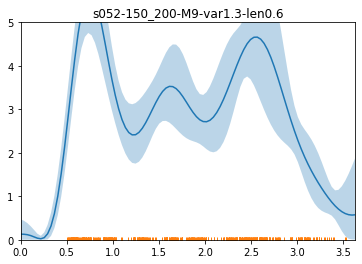

In [372]:
#画强度的估值图
X = domain_grid(domain, N)
lambda_mean, lower, upper = model.predict_lambda_and_percentiles(X)
lower = lower.numpy().flatten()
upper = upper.numpy().flatten()

title_object_4 = object_user+'-'+str(object_data_str_4)+'_'+str(object_data_end_4)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales)

plt.title(title_object_4)
plt.xlim(X.min(), X.max())
plt.ylim(0, 5)
plt.plot(X, lambda_mean)
plt.fill_between(X.flatten(), lower, upper, alpha=0.3)
plt.plot(events, np.zeros_like(events), '|')
plt.show()

In [373]:
N = 100     #预测点（lambda）
#目标用户信息,用于模型训练
object_data_str_5 = 200
object_data_end_5 = 250

'''
variance = 1.0
lengthscales = 0.6
inducing_num = 8
'''

events,num_observations = build_data(object_user,object_data_str_5, object_data_end_5,filename)
events = np.array(events, float).reshape(-1, 1)

domain_max = max(events) + 0.1
domain = [0,domain_max]
domain = np.array(domain, float).reshape(1, 2)

model = build_model(events, domain, num_observations, M=inducing_num, variance=variance, lengthscales = lengthscales)   #M是 inducing point的数量

def objective_closure():                           #目标函数
    return - model.elbo(events)

gpflow.optimizers.Scipy().minimize(objective_closure, model.trainable_variables)

      fun: -32.24963176113002
 hess_inv: <66x66 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.93194269e-02, -3.84989971e-02,  5.63645706e-03,  2.27878039e-02,
        6.63611840e-03,  2.69255399e-02, -2.49966682e-02,  6.82893479e-02,
       -1.83387300e-02, -1.39321293e-02, -2.78585725e-03,  2.40433201e-02,
       -8.26495265e-03, -3.15693189e-03, -6.94502582e-03, -2.27308654e-02,
        6.02805563e-03,  2.62029703e-02,  2.19359453e-02,  1.52416434e-02,
        1.97024062e-02,  8.68891824e-03,  1.83101744e-02,  1.16252324e-03,
        6.29178839e-03,  6.72503534e-03, -1.48731918e-04, -9.01844602e-03,
       -2.82195688e-04,  6.03834966e-03,  9.90340275e-03,  2.72606667e-02,
       -2.07602290e-02, -2.94335488e-03,  5.54763457e-04, -2.79613929e-03,
        8.25599065e-03,  1.97698418e-03, -2.67134972e-03, -4.15793383e-03,
       -2.63795904e-02, -1.61843065e-01,  1.40725433e-02,  1.41040751e-02,
       -1.10761155e-02,  1.02954275e-02,  1.45971520e-03,  3.51376448e-03,
 

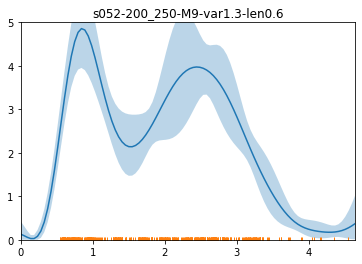

In [374]:
#画强度的估值图
X = domain_grid(domain, N)
lambda_mean, lower, upper = model.predict_lambda_and_percentiles(X)
lower = lower.numpy().flatten()
upper = upper.numpy().flatten()

title_object_5 = object_user+'-'+str(object_data_str_5)+'_'+str(object_data_end_5)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales)

plt.title(title_object_5)
plt.xlim(X.min(), X.max())
plt.ylim(0, 5)
plt.plot(X, lambda_mean)
plt.fill_between(X.flatten(), lower, upper, alpha=0.3)
plt.plot(events, np.zeros_like(events), '|')
plt.show()

In [375]:
N = 100     #预测点（lambda）
#目标用户信息,用于模型训练
object_data_str_6 = 250
object_data_end_6 = 300

'''
variance = 1.0
lengthscales = 0.5
inducing_num = 4
'''

events,num_observations = build_data(object_user,object_data_str_6, object_data_end_6,filename)
events = np.array(events, float).reshape(-1, 1)

domain_max = max(events) + 0.1
domain = [0,domain_max]
domain = np.array(domain, float).reshape(1, 2)

model = build_model(events, domain, num_observations, M=inducing_num, variance=variance, lengthscales = lengthscales)   #M是 inducing point的数量

def objective_closure():                           #目标函数
    return - model.elbo(events)

gpflow.optimizers.Scipy().minimize(objective_closure, model.trainable_variables)

      fun: -22.22696119131754
 hess_inv: <66x66 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00853626,  0.02837408, -0.07455164,  0.00052007,  0.03213066,
        0.02279714, -0.02572906,  0.00935465,  0.0130897 , -0.03166554,
        0.01903985,  0.00749042,  0.00788378,  0.00360637,  0.00122108,
       -0.00166462,  0.02413632,  0.00333558, -0.00813529,  0.02876696,
       -0.00846068,  0.02173593, -0.02042045,  0.02938694, -0.0068391 ,
        0.01312381,  0.00184441,  0.00159424, -0.00134739, -0.00625199,
        0.00586994,  0.05776491, -0.01108488, -0.01108873, -0.00499438,
       -0.00476194,  0.00280635,  0.00809199,  0.00079725, -0.02672306,
       -0.03741003,  0.03729707,  0.02766331, -0.00427887, -0.01034515,
        0.01123322,  0.00034354,  0.00117425, -0.02790384,  0.06667167,
       -0.31898924, -0.32100861,  0.00975053,  0.02524278, -0.02982796,
        0.00441044, -0.00846471, -0.01626251,  0.03389198,  0.04048879,
        0.08922713, -0.13137766, -0.0

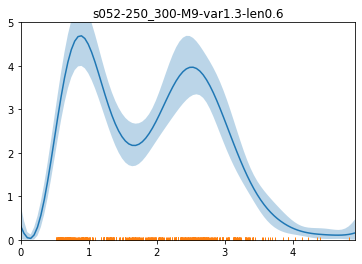

In [376]:
#画强度的估值图
X = domain_grid(domain, N)
lambda_mean, lower, upper = model.predict_lambda_and_percentiles(X)
lower = lower.numpy().flatten()
upper = upper.numpy().flatten()

title_object_6 = object_user+'-'+str(object_data_str_6)+'_'+str(object_data_end_6)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales)

plt.title(title_object_6)
plt.xlim(X.min(), X.max())
plt.ylim(0, 5)
plt.plot(X, lambda_mean)
plt.fill_between(X.flatten(), lower, upper, alpha=0.3)
plt.plot(events, np.zeros_like(events), '|')
plt.show()

In [377]:
N = 100     #预测点（lambda）
#目标用户信息,用于模型训练
object_data_str_7 = 300
object_data_end_7 = 350

'''
variance = 1.0
lengthscales = 0.5
inducing_num = 8
'''

events,num_observations = build_data(object_user,object_data_str_7, object_data_end_7,filename)
events = np.array(events, float).reshape(-1, 1)

domain_max = max(events) + 0.1
domain = [0,domain_max]
domain = np.array(domain, float).reshape(1, 2)

model = build_model(events, domain, num_observations, M=inducing_num, variance=variance, lengthscales = lengthscales)   #M是 inducing point的数量

def objective_closure():                           #目标函数
    return - model.elbo(events)

gpflow.optimizers.Scipy().minimize(objective_closure, model.trainable_variables)

      fun: -71.62717675882257
 hess_inv: <66x66 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00711642, -0.01852608,  0.00225157,  0.00347086, -0.15475222,
        0.04100674, -0.05472108,  0.03427522,  0.00111074, -0.08753316,
        0.04977524, -0.05099973, -0.03825277,  0.00514496,  0.00334713,
        0.05535131,  0.00302923,  0.02654084, -0.04989836,  0.00302161,
       -0.00814496, -0.00243191,  0.04000539, -0.0257322 ,  0.01113623,
       -0.00986165,  0.00672312,  0.00905272,  0.00327804, -0.00176294,
        0.07598861,  0.06568032,  0.00539032, -0.00544029, -0.0044544 ,
        0.00412164, -0.0043874 ,  0.0035104 ,  0.00371548,  0.04349943,
        0.01812752,  0.5164033 ,  0.0352745 ,  0.00259622, -0.00649358,
       -0.00910115, -0.00806758,  0.00539359,  0.04404646,  0.2149345 ,
       -0.65910315,  0.06304527,  0.01104454,  0.00332738, -0.02602511,
       -0.01835271,  0.0158434 ,  0.0092362 , -0.07509042, -0.13473427,
        0.2675732 , -0.03288196, -0.0

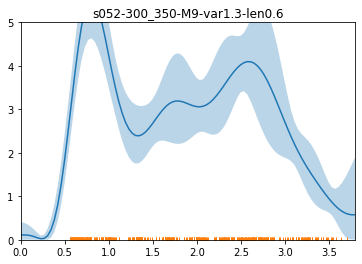

In [378]:
#画强度的估值图
X = domain_grid(domain, N)
lambda_mean, lower, upper = model.predict_lambda_and_percentiles(X)
lower = lower.numpy().flatten()
upper = upper.numpy().flatten()

title_object_7 = object_user+'-'+str(object_data_str_7)+'_'+str(object_data_end_7)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales)

plt.title(title_object_7)
plt.xlim(X.min(), X.max())
plt.ylim(0, 5)
plt.plot(X, lambda_mean)
plt.fill_between(X.flatten(), lower, upper, alpha=0.3)
plt.plot(events, np.zeros_like(events), '|')
plt.show()

In [379]:
N = 100     #预测点（lambda）
#目标用户信息,用于模型训练
object_data_str_8 = 350
object_data_end_8 = 400

'''
variance = 1.0
lengthscales = 0.5
inducing_num = 8
'''

events,num_observations = build_data(object_user,object_data_str_8, object_data_end_8,filename)
events = np.array(events, float).reshape(-1, 1)

domain_max = max(events) + 0.1
domain = [0,domain_max]
domain = np.array(domain, float).reshape(1, 2)

model = build_model(events, domain, num_observations, M=inducing_num, variance=variance, lengthscales = lengthscales)   #M是 inducing point的数量

def objective_closure():                           #目标函数
    return - model.elbo(events)

gpflow.optimizers.Scipy().minimize(objective_closure, model.trainable_variables)

      fun: -116.146277002098
 hess_inv: <66x66 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.26737265e-03,  6.11436311e-04, -6.23580702e-03,  7.47659015e-03,
       -1.48749083e-02, -4.62280939e-02,  3.63631484e-02, -2.75288652e-02,
       -2.81069663e-02,  6.69224080e-03,  1.78514150e-02, -1.02298111e-03,
       -1.35737987e-04,  2.39315747e-02,  1.87405463e-02, -4.20222732e-02,
        4.01258781e-03,  8.18320429e-03,  4.32501643e-02,  6.80829204e-03,
        5.72433679e-04, -4.94085117e-03, -1.74978483e-03, -2.25340819e-04,
        6.93090712e-04, -7.35930609e-04,  3.20593785e-04, -7.02711696e-04,
        1.74381341e-05,  4.29406520e-05, -2.24295217e-03,  2.20557605e-02,
        3.53380169e-03, -4.55776124e-03,  8.07150633e-03,  4.41872585e-03,
       -2.44752267e-03, -2.58773461e-04, -1.26399832e-04, -4.92094801e-03,
       -7.10679094e-03, -1.38145365e-01, -6.04151527e-03, -1.05009604e-02,
       -7.92506750e-03,  9.84286078e-03, -1.43989351e-03,  2.65968422e-04,
  

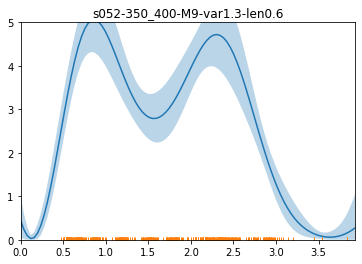

In [380]:
#画强度的估值图
X = domain_grid(domain, N)
lambda_mean, lower, upper = model.predict_lambda_and_percentiles(X)
lower = lower.numpy().flatten()
upper = upper.numpy().flatten()

title_object_8 = object_user+'-'+str(object_data_str_8)+'_'+str(object_data_end_8)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales)

plt.title(title_object_8)
plt.xlim(X.min(), X.max())
plt.ylim(0, 5)
plt.plot(X, lambda_mean)
plt.fill_between(X.flatten(), lower, upper, alpha=0.3)
plt.plot(events, np.zeros_like(events), '|')
plt.show()